# Lung Tumor Segmentation 3:
## Advanced Preprocessing

In [27]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from skimage.measure import regionprops
from scipy.ndimage import median_filter, gaussian_filter

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from glob import glob
import os
import matplotlib.pyplot as plt


In [28]:
def remove_artifacts(scan_slice, mask_slice, median_kernel_size=3, gaussian_sigma=1.0, threshold=None):
    """
    Remove artifacts from lung CT scan slice and corresponding mask slice.
    
    Parameters:
        scan_slice (np.ndarray): 2D numpy array representing the CT scan slice.
        mask_slice (np.ndarray): 2D numpy array representing the corresponding mask slice.
        median_kernel_size (int): Kernel size for median filtering. Default is 3.
        gaussian_sigma (float): Standard deviation for Gaussian filtering. Default is 1.0.
        threshold (float): Threshold value for intensity-based artifact removal. Default is None.
        
    Returns:
        denoised_scan (np.ndarray): Denoised CT scan slice.
        denoised_mask (np.ndarray): Corresponding denoised mask slice.
    """
    # Apply median filtering to remove salt-and-pepper noise and some motion artifacts
    denoised_scan = median_filter(scan_slice, size=median_kernel_size)
    
    # Apply Gaussian filtering to smooth out noise and reduce remaining artifacts
    denoised_scan = gaussian_filter(denoised_scan, sigma=gaussian_sigma)
    
    # Apply intensity-based artifact removal if threshold is provided
    if threshold is not None:
        denoised_scan = np.where(denoised_scan > threshold, denoised_scan, 0)
    
    # Ensure mask remains binary after filtering
    denoised_mask = np.where(mask_slice > 0, 1, 0)
    
    return denoised_scan, denoised_mask


In [29]:
def artifact_removal_pipeline(scan_slices, mask_slices, median_kernel_size=3, gaussian_sigma=1.0, threshold=None):
    """
    Pipeline for artifact removal in lung CT scans and corresponding masks.
    
    Parameters:
        scan_slices (List[np.ndarray]): List of 2D numpy arrays representing CT scan slices.
        mask_slices (List[np.ndarray]): List of 2D numpy arrays representing corresponding mask slices.
        median_kernel_size (int): Kernel size for median filtering. Default is 3.
        gaussian_sigma (float): Standard deviation for Gaussian filtering. Default is 1.0.
        threshold (float): Threshold value for intensity-based artifact removal. Default is None.
        
    Returns:
        denoised_scans (List[np.ndarray]): List of denoised CT scan slices.
        denoised_masks (List[np.ndarray]): List of denoised mask slices.
    """
    denoised_scans = []
    denoised_masks = []
    
    for scan_slice, mask_slice in zip(scan_slices, mask_slices):
        denoised_scan, denoised_mask = remove_artifacts(scan_slice, mask_slice, median_kernel_size, gaussian_sigma, threshold)
        denoised_scans.append(denoised_scan)
        denoised_masks.append(denoised_mask)
    
    return denoised_scans, denoised_masks

In [30]:
def visualize_results(original_scan_slice, original_mask_slice, denoised_scan_slice, denoised_mask_slice):
    """
    Visualize original and denoised CT scan slices with corresponding masks.
    
    Parameters:
        original_scan_slice (np.ndarray): Original CT scan slice.
        original_mask_slice (np.ndarray): Original mask slice.
        denoised_scan_slice (np.ndarray): Denoised CT scan slice.
        denoised_mask_slice (np.ndarray): Denoised mask slice.
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axes[0, 0].imshow(original_scan_slice, cmap='gray')
    axes[0, 0].set_title('Original Scan')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_mask_slice, cmap='gray')
    axes[0, 1].set_title('Original Mask')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(denoised_scan_slice, cmap='gray')
    axes[1, 0].set_title('Denoised Scan')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(denoised_mask_slice, cmap='gray')
    axes[1, 1].set_title('Denoised Mask')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()




In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Set paths
image_dir = '/kaggle/input/lung-cancer-segmentation-preprocessed/images/'
mask_dir = '/kaggle/input/lung-cancer-segmentation-preprocessed/labels/'

# Get list of file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.npy')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.npy')]

# Load images and masks
images = [np.load(os.path.join(image_dir, img)) for img in image_files]
masks = [np.load(os.path.join(mask_dir, mask)) for mask in mask_files]

In [6]:
images[6].max()

0.0035544003

In [7]:
su = 0
max_u = -0.0002
for im in images:
    su += im.max()
    if(im.max() > max_u):
        max_u = im.max()
print(su/len(images))
print(max_u)

0.0027177192016819202
0.0039215693


In [8]:
images = [img * 255.0 for img in images]

In [39]:
denoised_scans, denoised_masks = artifact_removal_pipeline(images[:5], masks[:5])

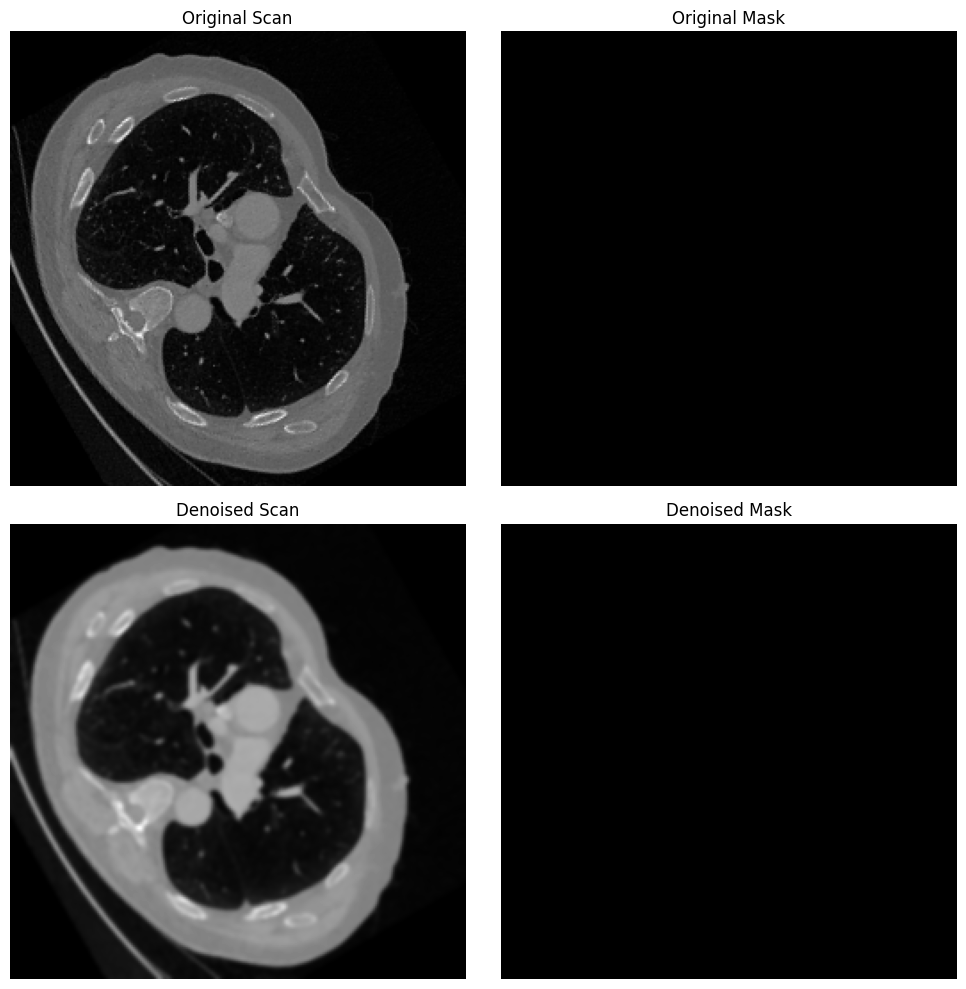

In [40]:
# Example usage
original_scan_slice = images[0]  # Original CT scan slice
original_mask_slice = masks[0]  # Original mask slice
denoised_scan_slice = denoised_scans[0]  # Denoised CT scan slice
denoised_mask_slice = denoised_masks[0]  # Denoised mask slice

visualize_results(original_scan_slice, original_mask_slice, denoised_scan_slice, denoised_mask_slice)

In [9]:
def build_laplacian_pyramid(img, levels):
    """
    Build the Laplacian Pyramid for the given image and number of levels.
    """
    pyramid = []
    gaussian_pyramid = [img]
    
    for level in range(levels):  # Corrected line
        prev_gaussian = gaussian_pyramid[level]
        curr_gaussian = cv2.pyrDown(prev_gaussian)
        gaussian_pyramid.append(curr_gaussian)
        
        laplacian = prev_gaussian - cv2.pyrUp(curr_gaussian, dstsize=prev_gaussian.shape[:2])
        pyramid.append(laplacian)
    
    pyramid.append(gaussian_pyramid[-1])  # Add the residual
    
    return pyramid

In [10]:
def merge_laplacian_pyramid(pyramid):
    """
    Merge the Laplacian Pyramid levels back into an image.
    """
    laplacian_pyramid = list(pyramid)
    
    for level in range(len(laplacian_pyramid) - 1, 0, -1):
        laplacian = laplacian_pyramid[level - 1]
        upsampled = cv2.pyrUp(laplacian_pyramid[level], dstsize=laplacian.shape[:2])
        laplacian_pyramid[level - 1] = laplacian + upsampled
    
    return laplacian_pyramid[0]

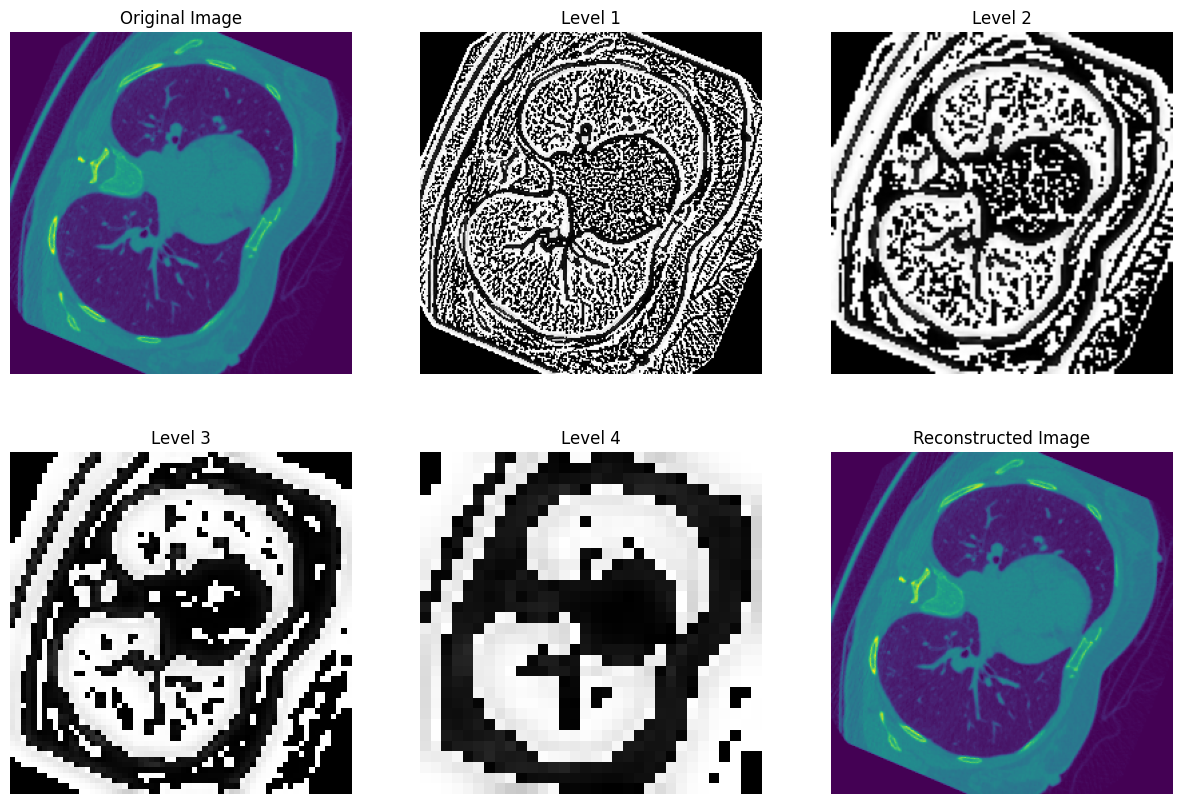

In [21]:
scan_i = 1
# Load an example image from your training data
scan_data = images[scan_i]
example_mask = masks[scan_i]
# Normalize the scan data to the range [0, 255] for visualization
normalized_scan = (scan_data - scan_data.min()) / (scan_data.max() - scan_data.min()) * 255
normalized_scan = normalized_scan.astype(np.uint8)

# Build the Laplacian Pyramid
levels = 4
laplacian_pyramid = build_laplacian_pyramid(normalized_scan, levels)

# Visualize the Laplacian Pyramid levels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes[0, 0].imshow(normalized_scan)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, level in enumerate(laplacian_pyramid[:-1]):
    row, col = divmod(i + 1, 3)
    axes[row, col].imshow(level, cmap='gray')
    axes[row, col].set_title(f'Level {i + 1}')
    axes[row, col].axis('off')

# Reconstruct the image from the Laplacian Pyramid
reconstructed_scan = merge_laplacian_pyramid(laplacian_pyramid)

axes[1, 2].imshow(reconstructed_scan)
axes[1, 2].set_title('Reconstructed Image')
axes[1, 2].axis('off')

plt.show()

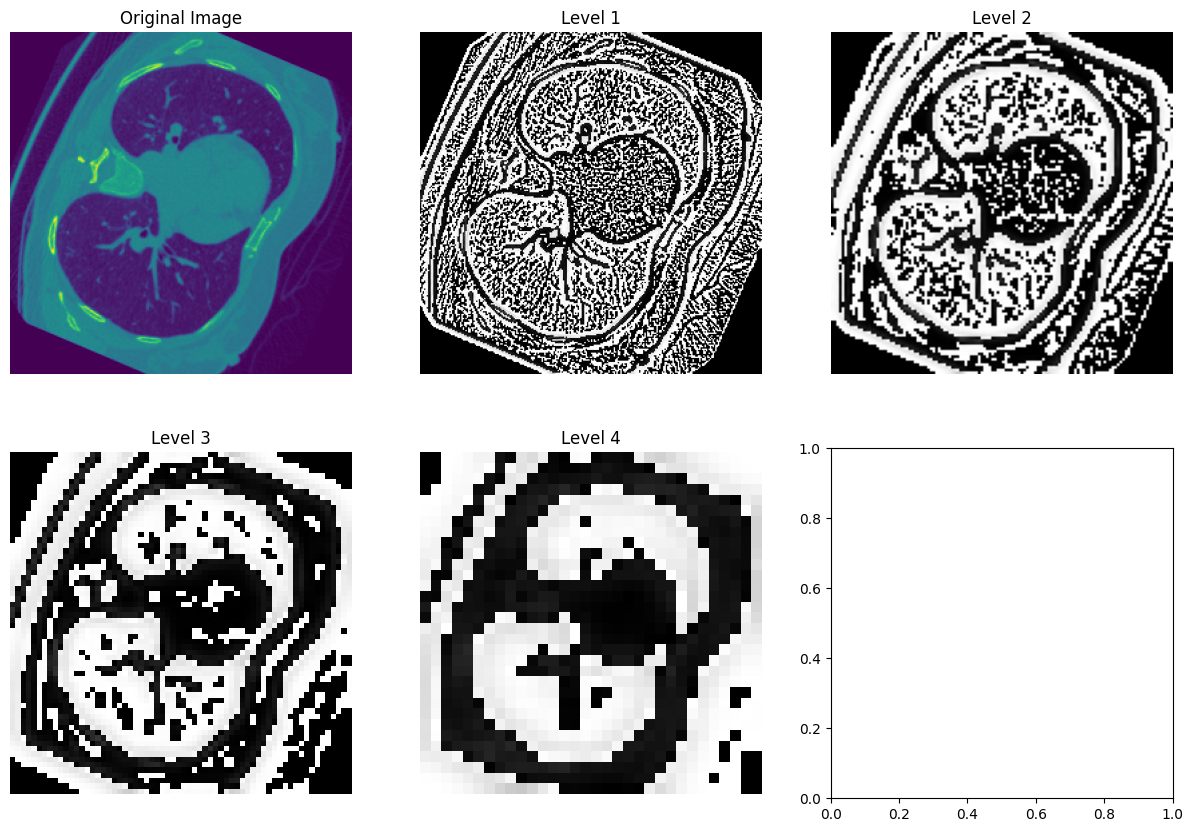

In [22]:
# Visualize the Laplacian Pyramid levels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes[0, 0].imshow(normalized_scan)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, level in enumerate(laplacian_pyramid[:-1]):
    row, col = divmod(i + 1, 3)
    axes[row, col].imshow(level, cmap='gray')
    axes[row, col].set_title(f'Level {i + 1}')
    axes[row, col].axis('off')


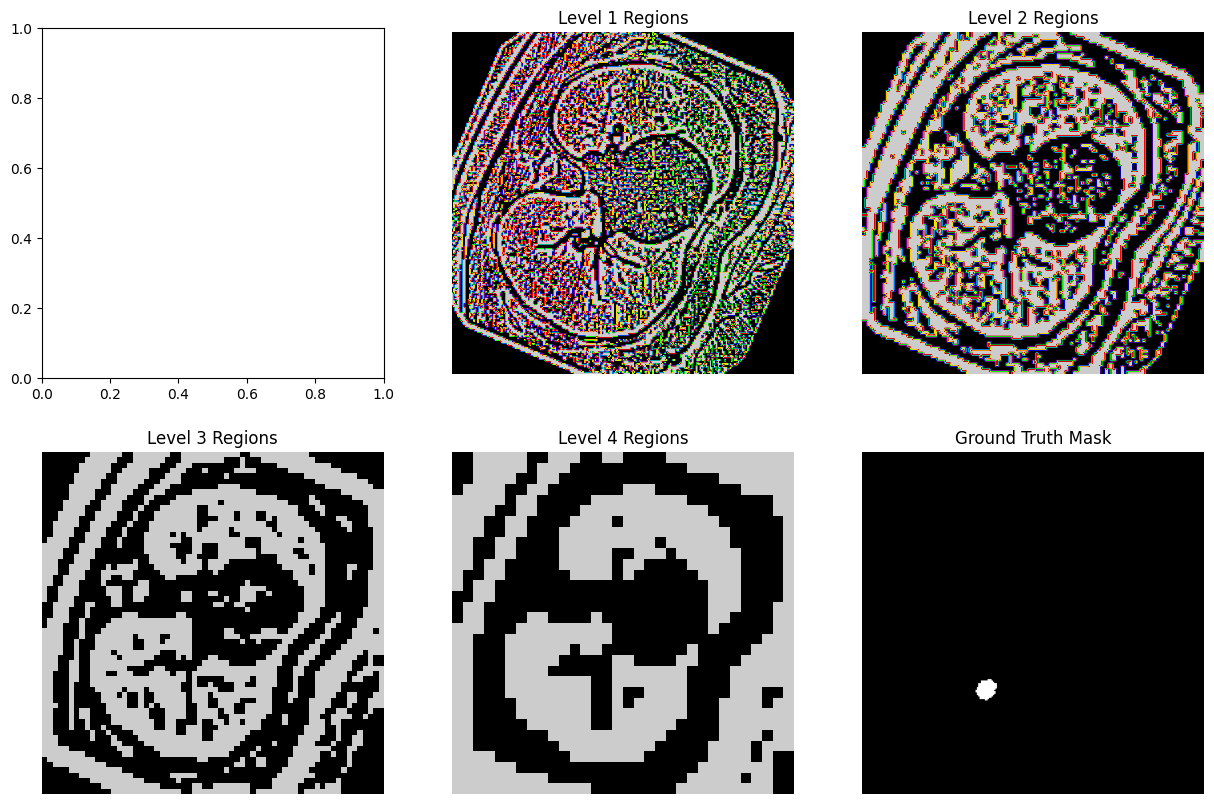

In [23]:
# Visualize the relationship between Laplacian Pyramid levels and segmentation masks
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, level in enumerate(laplacian_pyramid[:-1]):
    row, col = divmod(i + 1, 3)
    level_mask = (level > level.mean()).astype(int)
    regions = regionprops(level_mask)
    regions_mask = np.zeros_like(level_mask)
    for region in regions:
        regions_mask[region.coords[:, 0], region.coords[:, 1]] = region.label
    axes[row, col].imshow(regions_mask, cmap='nipy_spectral')
    axes[row, col].set_title(f'Level {i + 1} Regions')
    axes[row, col].axis('off')

axes[1, 2].imshow(example_mask, cmap='gray')
axes[1, 2].set_title('Ground Truth Mask')
axes[1, 2].axis('off')

plt.show()